# Test of PS_Fullmodel_1step by LBNL (Slimming level 1)

Setteing of circuits

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
from sample_algorithm.onestepSim_LBNL import runQuantum
circuit_LBNL1 = runQuantum(gLR=1,dophisplit=1)

In [37]:
from transpiler.optimization import slim
example1 = slim.circuit_optimization( circuit=circuit_LBNL1, slim_level=1, work_register = 'w', cut='high')
circuit_LBNL1_op = example1.slim()
circuit_LBNL1 = runQuantum(gLR=1,dophisplit=1)

In [5]:
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram

In [6]:
from qiskit import *
def statevector(circ):
    circ.remove_final_measurements()
    simulator = Aer.get_backend('statevector_simulator')
    job = execute(circ, simulator)
    result = job.result()
    statevector = result.get_statevector(circ)
    return qiskit.quantum_info.Statevector(statevector).probabilities_dict()

## New Optimizer vs Qiskit

### Before slimming

In [7]:
print(circuit_LBNL1.depth(), ',', circuit_LBNL1.__len__())
print('Gate counts:', circuit_LBNL1.count_ops())

46 , 66
Gate counts: OrderedDict([('ccx', 28), ('x', 19), ('cu3', 7), ('measure', 6), ('cx', 5), ('barrier', 1)])


In [8]:
circuit_LBNL1_basis = circuit_LBNL1.decompose()
print(circuit_LBNL1_basis.depth(), ',', circuit_LBNL1_basis.__len__())
print('Gate counts:', circuit_LBNL1_basis.count_ops())

309 , 493
Gate counts: OrderedDict([('cx', 187), ('t', 112), ('tdg', 84), ('h', 56), ('u3', 33), ('u1', 14), ('measure', 6), ('barrier', 1)])


### After slimming

In [28]:
print(circuit_LBNL1_op.depth(), ',', circuit_LBNL1_op.__len__())
print('Gate counts:', circuit_LBNL1_op.count_ops())

43 , 53
Gate counts: OrderedDict([('cx', 29), ('x', 7), ('measure', 6), ('cry', 4), ('ccx', 4), ('ry', 2), ('barrier', 1)])


In [29]:
circuit_LBNL1_op_basis = circuit_LBNL1_op.decompose()
print(circuit_LBNL1_op_basis.depth(), ',', circuit_LBNL1_op_basis.__len__())
print('Gate counts:', circuit_LBNL1_op_basis.count_ops())

83 , 121
Gate counts: OrderedDict([('cx', 61), ('t', 16), ('u3', 15), ('tdg', 12), ('h', 8), ('measure', 6), ('r', 2), ('barrier', 1)])


{'000 100': 11724, '000 101': 10651, '001 100': 51197, '001 101': 8348}


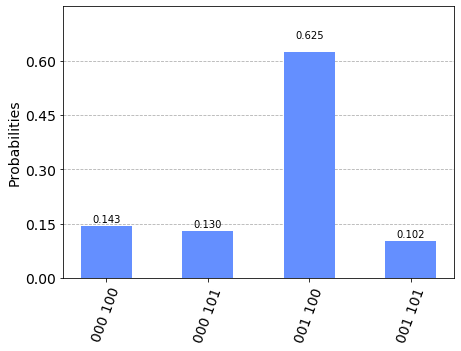

In [30]:
circuit=circuit_LBNL1_op
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=81920)
result = job.result()
counts = result.get_counts(circuit)

print(counts)
plot_histogram(counts,number_to_keep=None)

In [31]:
statevector(circuit_LBNL1_op)

{'0000000000100': 0.14101480996166701,
 '0000000000101': 0.13079599534594055,
 '0000001001100': 2.1148834074021317e-33,
 '0000001001101': 1.9616257355306923e-33,
 '0000010000100': 5.848127609975192e-32,
 '0000010000101': 1.27484393387346e-32,
 '0000011001100': 0.6271510543561875,
 '0000011001101': 0.10103814033620451}

In [32]:
print(81920*(0.14101480996166701))
print(81920*(0.13079599534594055))
print(81920*0.627151054356188)
print(81920*0.10103814033620448)

11551.933232059762
10714.80793873945
51376.21437285892
8277.044456341871


## New Optimizer vs tket

In [14]:
from pytket.qiskit import qiskit_to_tk, tk_to_qiskit
from pytket.passes import (RemoveRedundancies, CommuteThroughMultis, CliffordSimp, RebaseIBM, O2Pass,
                           FullPeepholeOptimise, EulerAngleReduction, USquashIBM, SynthesiseIBM, PauliSimp,
                           GuidedPauliSimp, OptimisePhaseGadgets, SquashHQS, FlattenRegisters, KAKDecomposition,
                           RepeatPass, SequencePass)
from pytket import OpType

### Before slimming

In [15]:
def passes2(circ_tk):
    pass_list=[EulerAngleReduction(OpType.Rz, OpType.Rx),
    RemoveRedundancies(),
    GuidedPauliSimp(),
    SquashHQS(),
    FlattenRegisters(),
    OptimisePhaseGadgets(),
    KAKDecomposition(),
    USquashIBM(),
    CliffordSimp(),
    FullPeepholeOptimise()]
    
    RebaseIBM().apply(circ_tk)
    CommuteThroughMultis().apply(circ_tk)
    
    circ_tk_qiskit_copy = tk_to_qiskit(circ_tk)
    circ_tk_copy = qiskit_to_tk(circ_tk_qiskit_copy)
    
    best_pass = RebaseIBM()
    mini = tk_to_qiskit(circ_tk).__len__()
    for a_pass in pass_list:
        #print(tk_to_qiskit(circ_tk_copy).__len__())
        a_pass.apply(circ_tk_copy)
        if circ_tk_copy.n_gates < mini :
            mini = circ_tk_copy.n_gates
            best_pass = a_pass
        circ_tk_qiskit_copy = tk_to_qiskit(circ_tk)
        circ_tk_copy = qiskit_to_tk(circ_tk_qiskit_copy)
        
    best_pass.apply(circ_tk)
        
    return circ_tk

In [16]:
circ = circuit_LBNL1
mystate_reduct_tk = qiskit_to_tk(circ)
RebaseIBM().apply(mystate_reduct_tk)

while tk_to_qiskit(mystate_reduct_tk).__len__() != tk_to_qiskit(passes2(mystate_reduct_tk)).__len__() :
    mystate_reduct_tk = passes2(mystate_reduct_tk)

mystate_reduct_qiskit=tk_to_qiskit(mystate_reduct_tk)

In [17]:
print(mystate_reduct_qiskit.depth(), ',', mystate_reduct_qiskit.__len__())
print('Gate counts:', mystate_reduct_qiskit.count_ops())

279 , 367
Gate counts: OrderedDict([('cx', 185), ('u1', 108), ('u3', 67), ('measure', 6), ('barrier', 1)])


{'000 100': 11574, '000 101': 10592, '001 100': 51395, '001 101': 8359}


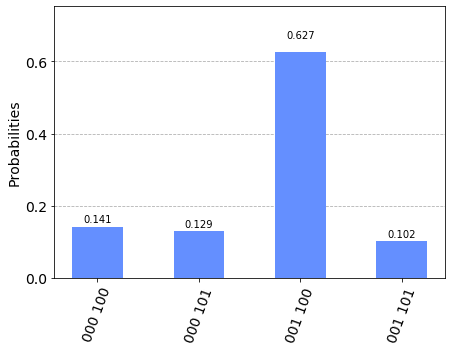

In [18]:
circuit=mystate_reduct_qiskit
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=81920)
result = job.result()
counts = result.get_counts(circuit)

print(counts)
plot_histogram(counts,number_to_keep=None)

In [19]:
for key,value in statevector(mystate_reduct_qiskit).items():
    if value > 0.0000001:
        print(key,value)

000000001000000 0.14101480996166776
000000001010000 0.1307959953459411
000000011001100 0.6271510543561895
000000011011100 0.1010381403362049


In [20]:
print(81920*(0.14101480996166776))
print(81920*(0.1307959953459411))
print(81920*0.6271510543561895)
print(81920*0.1010381403362049)

11551.933232059822
10714.807938739496
51376.21437285904
8277.044456341904


### After slimming

In [38]:
circ = circuit_LBNL1_op
mystate_reduct_tk = qiskit_to_tk(circ)
RebaseIBM().apply(mystate_reduct_tk)

while tk_to_qiskit(mystate_reduct_tk).__len__() != tk_to_qiskit(passes2(mystate_reduct_tk)).__len__() :
    mystate_reduct_tk = passes2(mystate_reduct_tk)

mystate_reduct_qiskit_op=tk_to_qiskit(mystate_reduct_tk)

In [40]:
print(mystate_reduct_qiskit_op.depth(), ',', mystate_reduct_qiskit_op.__len__())
print('Gate counts:', mystate_reduct_qiskit_op.count_ops())

68 , 95
Gate counts: OrderedDict([('cx', 50), ('u3', 22), ('u1', 16), ('measure', 6), ('barrier', 1)])


{'000 100': 11372, '000 101': 10772, '001 100': 51456, '001 101': 8320}


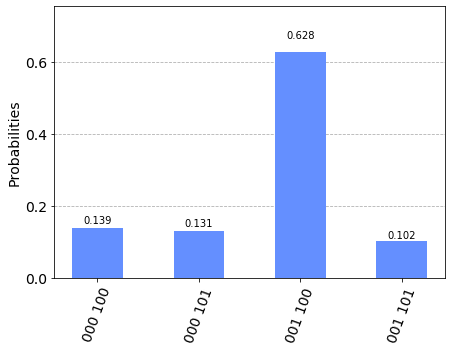

In [41]:
circuit=mystate_reduct_qiskit_op
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=81920)
result = job.result()
counts = result.get_counts(circuit)

print(counts)
plot_histogram(counts,number_to_keep=None)

In [42]:
for key,value in statevector(mystate_reduct_qiskit_op).items():
    if value > 0.0000001:
        print(key,value)

0000001000000 0.1410148099616668
0000001010000 0.13079599534594022
0000011001100 0.6271510543561889
0000011011100 0.10103814033620487


In [43]:
print(81920*(0.1410148099616668))
print(81920*(0.13079599534594022))
print(81920*0.6271510543561889)
print(81920*0.10103814033620487)

11551.933232059744
10714.807938739423
51376.214372858994
8277.044456341902


# Conclusion
・qiskit+my_optimizer > qiskit
<br>
・tket+my_optimizer > tket

In [17]:
circ_list = [circuit_LBNL1_basis, circuit_LBNL1_op_basis, mystate_reduct_qiskit, mystate_reduct_qiskit_op]

In [18]:
depth_list = [circuit_LBNL1_basis.depth(), circuit_LBNL1_op_basis.depth(), mystate_reduct_qiskit.depth(),
             mystate_reduct_qiskit_op.depth()]

[309, 486, 187, 299]
[83, 114, 61, 53]
[279, 360, 185, 175]
[68, 88, 50, 38]


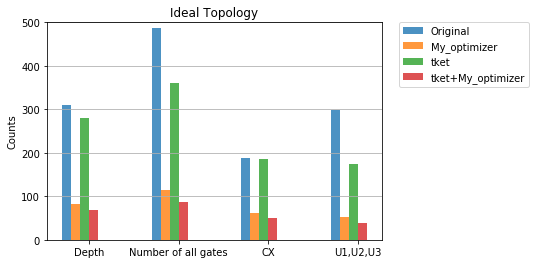

In [19]:
import matplotlib.pyplot as plt
import numpy as np

n = 4
index = np.arange(n)
fig, ax = plt.subplots()
bar_width = 0.1
alpha = 0.8


name_list=['Original','My_optimizer','tket','tket+My_optimizer']

for i,circ in enumerate(circ_list):
    native_gate_num =[depth_list[i],0,0,0]
    for key,value in circ.count_ops().items():
        if key == 'cx':
            native_gate_num[2] += value
            native_gate_num[1] += value
        elif key != 'barrier' and key != 'measure':
            native_gate_num[3] += value
            native_gate_num[1] += value
            
    plt.bar(index + i*bar_width, native_gate_num, bar_width, alpha=alpha ,label=name_list[i])
    
    print(native_gate_num)

plt.ylim([0,500])
plt.title('Ideal Topology') # グラフのタイトル plt.xlabel('x')
plt.ylabel('Counts')
plt.xticks(index + 2.5*bar_width, ('Depth','Number of all gates','CX', 'U1,U2,U3'))
plt.grid(axis = 'y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()